In [26]:
!gdown --id 1dWfWzaISPR1Cv4tR0EtNhD1jQODV0Kp9 # train test key
!gdown --id 1ji2idP3o37gQmyR-x-n849LbhmxilxPG # full dataset
!gdown --id 1bIiROVpdUmX9af-La19asq3UXoNlR3-S # util

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dWfWzaISPR1Cv4tR0EtNhD1jQODV0Kp9
To: /content/train_test_key.csv
100% 7.86k/7.86k [00:00<00:00, 13.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ji2idP3o37gQmyR-x-n849LbhmxilxPG
To: /content/USDM_SMAP_SET_NOAA_STL_full.csv
100% 55.0M/55.0M [00:00<00:00, 216MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning

In [27]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from util import *
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor


import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import sklearn.linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import sklearn.impute as im
from sklearn.preprocessing import PolynomialFeatures

from datetime import timedelta
from datetime import datetime
from tqdm import tqdm

from sklearn import preprocessing


# Data processing

## train/test keys

In [28]:
ttkey=pd.read_csv('train_test_key.csv',dtype=str)
trkey=ttkey.iloc[:,0]
trkey=[int(i) for i in list(trkey.to_numpy())]
tekey=ttkey.iloc[:,2].dropna(axis=0)
tekey=[int(i) for i in list(tekey.to_numpy())]

In [29]:
len(trkey),len(tekey)

(360, 90)

## subsetting dataset

In [30]:
df=pd.read_csv('USDM_SMAP_SET_NOAA_STL_full.csv')
df[df==-9999]=np.nan
df['MapDate']=pd.to_datetime(df['MapDate'])

# Threshold
df['Y']=np.where(df['None']==100,0,1)

cache=df[['MapDate', 'FIPS STR', 'Y', 'roff', 'evap', 'Region']]
cache=cache.rename(columns={'FIPS STR':'FIPS_STR'})
dfs=cache.dropna()

dfs['dT']=[np.timedelta64(dfs['MapDate'].to_numpy()[i]-dfs['MapDate'].to_numpy()[0],'W').astype(int) for i in range(dfs.shape[0])]
dfs

,MapDate,FIPS_STR,Y,roff,evap,Region,dT
157,2014-12-30,1007,0,0.001730,-3.701072e-04,Southeast,0
158,2015-01-06,1007,0,0.000068,-9.940644e-05,Southeast,1
159,2015-01-13,1007,0,0.000077,-1.348449e-04,Southeast,2
160,2015-01-20,1007,0,0.000395,-3.874424e-04,Southeast,3
161,2015-01-27,1007,0,0.000193,-2.163508e-04,Southeast,4
...,...,...,...,...,...,...,...
238937,2021-11-30,56043,1,0.000002,-2.076237e-05,NorthernRR,361
238938,2021-12-07,56043,1,0.000002,-8.488739e-06,NorthernRR,362
238939,2021-12-14,56043,1,0.000002,-5.072568e-05,NorthernRR,363
238940,2021-12-21,56043,1,0.000002,-2.681730e-05,NorthernRR,364


# onehot encoding

In [31]:
onehot = pd.get_dummies(dfs.Region, prefix='Region')
onehot.head()
onehot.columns

Index(['Region_Northeast', 'Region_NorthernRR', 'Region_Northwest',
       'Region_OhioValley', 'Region_South', 'Region_Southeast',
       'Region_Southwest', 'Region_UpperMidwest', 'Region_West'],
      dtype='object')

In [32]:
dfs = pd.concat([dfs, onehot], axis=1)
dfs

,MapDate,FIPS_STR,Y,roff,evap,Region,dT,Region_Northeast,Region_NorthernRR,Region_Northwest,Region_OhioValley,Region_South,Region_Southeast,Region_Southwest,Region_UpperMidwest,Region_West
157,2014-12-30,1007,0,0.001730,-3.701072e-04,Southeast,0,0,0,0,0,0,1,0,0,0
158,2015-01-06,1007,0,0.000068,-9.940644e-05,Southeast,1,0,0,0,0,0,1,0,0,0
159,2015-01-13,1007,0,0.000077,-1.348449e-04,Southeast,2,0,0,0,0,0,1,0,0,0
160,2015-01-20,1007,0,0.000395,-3.874424e-04,Southeast,3,0,0,0,0,0,1,0,0,0
161,2015-01-27,1007,0,0.000193,-2.163508e-04,Southeast,4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238937,2021-11-30,56043,1,0.000002,-2.076237e-05,NorthernRR,361,0,1,0,0,0,0,0,0,0
238938,2021-12-07,56043,1,0.000002,-8.488739e-06,NorthernRR,362,0,1,0,0,0,0,0,0,0
238939,2021-12-14,56043,1,0.000002,-5.072568e-05,NorthernRR,363,0,1,0,0,0,0,0,0,0
238940,2021-12-21,56043,1,0.000002,-2.681730e-05,NorthernRR,364,0,1,0,0,0,0,0,0,0


In [33]:
x = dfs[['roff','evap']]

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

dfs[['roff','evap']] = x_scaled
dfs

,MapDate,FIPS_STR,Y,roff,evap,Region,dT,Region_Northeast,Region_NorthernRR,Region_Northwest,Region_OhioValley,Region_South,Region_Southeast,Region_Southwest,Region_UpperMidwest,Region_West
157,2014-12-30,1007,0,0.079467,0.809836,Southeast,0,0,0,0,0,0,1,0,0,0
158,2015-01-06,1007,0,0.003141,0.868397,Southeast,1,0,0,0,0,0,1,0,0,0
159,2015-01-13,1007,0,0.003559,0.860731,Southeast,2,0,0,0,0,0,1,0,0,0
160,2015-01-20,1007,0,0.018149,0.806085,Southeast,3,0,0,0,0,0,1,0,0,0
161,2015-01-27,1007,0,0.008843,0.843098,Southeast,4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238937,2021-11-30,56043,1,0.000113,0.885411,NorthernRR,361,0,1,0,0,0,0,0,0,0
238938,2021-12-07,56043,1,0.000094,0.888066,NorthernRR,362,0,1,0,0,0,0,0,0,0
238939,2021-12-14,56043,1,0.000113,0.878928,NorthernRR,363,0,1,0,0,0,0,0,0,0
238940,2021-12-21,56043,1,0.000112,0.884101,NorthernRR,364,0,1,0,0,0,0,0,0,0


In [34]:
yy=dfs.Y.to_numpy()
np.sum(yy)/len(yy)

0.4983630898049095

In [35]:
# check if date matched
# dfs.groupby('FIPS_STR').count(),dfs.groupby('FIPS_STR').count().nunique()

## WARNING: county 45019 is NaN. please check original datasets.

In [36]:
dfs_fips=dfs['FIPS_STR'].unique()
for i in trkey:
  if i in dfs_fips: pass
  else: print(i)

45019


In [37]:
df[df['FIPS STR']==45019].roff

185850   NaN
185851   NaN
185852   NaN
185853   NaN
185854   NaN
          ..
186376   NaN
186377   NaN
186378   NaN
186379   NaN
186380   NaN
Name: roff, Length: 531, dtype: float64

#### TRAIN ON TRAINING SET'S WEEK 0   TO 285
#### TEST  ON TESTING SET'S  WEEK 286 TO 365

In [38]:
print('train')
print(timekey(horizon=4, nhist=8,thin=False,total_days=286,test=False)[:5])
print('test:')
print(timekey(horizon=4, nhist=8,thin=False,total_days=286,test=True)[:5])

train
[(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 8,  9, 10, 11])), (array([1, 2, 3, 4, 5, 6, 7, 8]), array([ 9, 10, 11, 12])), (array([2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13])), (array([ 3,  4,  5,  6,  7,  8,  9, 10]), array([11, 12, 13, 14])), (array([ 4,  5,  6,  7,  8,  9, 10, 11]), array([12, 13, 14, 15]))]
test:
[(array([286, 287, 288, 289, 290, 291, 292, 293]), array([294, 295, 296, 297])), (array([287, 288, 289, 290, 291, 292, 293, 294]), array([295, 296, 297, 298])), (array([288, 289, 290, 291, 292, 293, 294, 295]), array([296, 297, 298, 299])), (array([289, 290, 291, 292, 293, 294, 295, 296]), array([297, 298, 299, 300])), (array([290, 291, 292, 293, 294, 295, 296, 297]), array([298, 299, 300, 301]))]


In [39]:
gen=False

In [45]:
horizon_=10
nhist_=26
feature_name=['Y', 'roff', 'evap','Region_Northeast', 'Region_NorthernRR', 'Region_Northwest',
      'Region_OhioValley', 'Region_South', 'Region_Southeast',
      'Region_Southwest', 'Region_UpperMidwest', 'Region_West']
thin=False
  
if gen==True:

  tkey=timekey(horizon=horizon_, nhist=nhist_,thin=thin,total_days=286,test=False)
  label_key=np.array(tkey)[:,1]
  feature_key=np.array(tkey)[:,0]

  shape_=len(feature_name)*nhist_

  x_tr,y_tr=[],[]
  for i in tqdm(trkey):
    cache=dfs[dfs['FIPS_STR']==i]
    if cache.shape[0]==0: 
      print('passed county:', i)
      pass
    else:
      for j in np.arange(1,len(label_key)):
        feature=cache[cache['dT'].isin(feature_key[j])][feature_name].to_numpy()
        label=cache[cache['dT'].isin(label_key[j])]['Y'].to_numpy()
        # print(feature,label)
        # break
        
        x_tr.append(feature)
        y_tr.append(label)


  x_te,y_te=[],[]
  for i in tqdm(tekey):
    cache=dfs[dfs['FIPS_STR']==i]
    if cache.shape[0]==0: 
      print('passed county:', i)
      pass
    else:
      for j in np.arange(1,len(label_key)):
        feature=cache[cache['dT'].isin(feature_key[j])][feature_name].to_numpy()
        label=cache[cache['dT'].isin(label_key[j])]['Y'].to_numpy()
        
        x_te.append(feature)
        y_te.append(label)

  x_tr_np=np.array(x_tr)
  y_tr_np=np.array(y_tr)

  x_te_np=np.array(x_te)
  y_te_np=np.array(y_te)


  from google.colab import drive
  drive.mount('/content/drive')
  np.savez('drive/MyDrive/HWs/data',np.array([x_tr_np,y_tr_np,x_te_np,y_te_np]))
  
else:
  !gdown 1-3Abm7XSbcnVaV138um4UrTOQv6lV8pU
  npzfile = np.load('data.npz',allow_pickle=True)
  x_tr_np,y_tr_np,x_te_np,y_te_np=npzfile['arr_0'][0],npzfile['arr_0'][1],npzfile['arr_0'][2],npzfile['arr_0'][3]

Downloading...
From: https://drive.google.com/uc?id=1-3Abm7XSbcnVaV138um4UrTOQv6lV8pU
To: /content/data.npz
100% 289M/289M [00:01<00:00, 153MB/s]


In [46]:
x_tr_np[1].shape

(26, 12)

Text(0.5, 0.98, '2D Visualization of climate history')

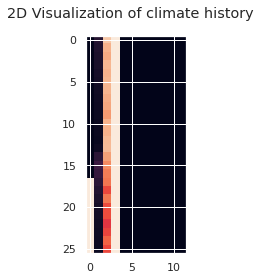

In [47]:
plt.imshow(x_tr_np[1])
plt.suptitle('2D Visualization of climate history')

# $X_{t-26 \to t}: Y_{t+1 \to t+10}$

In [48]:
def DroughtNet():
  NN_model = Sequential()

  #input and conv layers
  NN_model.add(Conv2D(32, (3, 3), activation='relu',input_shape = [26,len(feature_name),1]))
  NN_model.add(MaxPooling2D())
  NN_model.add(Conv2D(64, (3, 3), activation='relu'))
  NN_model.add(MaxPooling2D())
  NN_model.add(Flatten()) 
  
  #dense classification layers
  NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dropout(0.2))
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dropout(0.2))
  NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dropout(0.2))
  NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dropout(0.2))

  #output layer
  NN_model.add(Dense(10,activation='sigmoid'))

  NN_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=tf.metrics.BinaryAccuracy(threshold=0.8))
  return NN_model


model=DroughtNet()
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 10, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 5, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 3, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 1, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 512)              

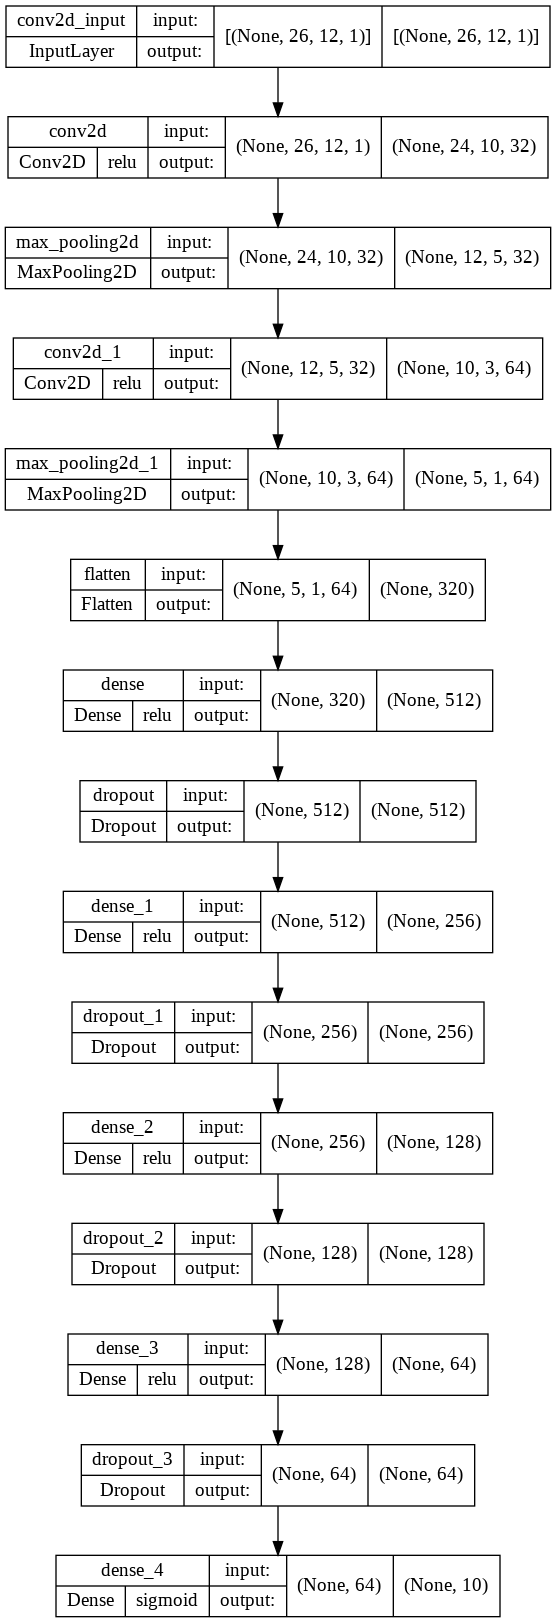

In [51]:
tf.keras.utils.plot_model(model, show_layer_activations=True,show_shapes=True)

In [57]:
hist = model.fit(x_tr_np,y_tr_np,batch_size=32,epochs=200)

Epoch 1/200
2805/2805 [==============================] - 20s 7ms/step - loss: 0.3137 - binary_accuracy: 0.8192
Epoch 2/200
2805/2805 [==============================] - 18s 6ms/step - loss: 0.3111 - binary_accuracy: 0.8215
Epoch 3/200
2805/2805 [==============================] - 17s 6ms/step - loss: 0.3082 - binary_accuracy: 0.8236
Epoch 4/200
2805/2805 [==============================] - 18s 6ms/step - loss: 0.3062 - binary_accuracy: 0.8253
Epoch 5/200
2805/2805 [==============================] - 18s 6ms/step - loss: 0.3033 - binary_accuracy: 0.8266
Epoch 6/200
2805/2805 [==============================] - 18s 6ms/step - loss: 0.3014 - binary_accuracy: 0.8281
Epoch 7/200
2805/2805 [==============================] - 18s 6ms/step - loss: 0.2991 - binary_accuracy: 0.8302
Epoch 8/200
2805/2805 [==============================] - 17s 6ms/step - loss: 0.2966 - binary_accuracy: 0.8314
Epoch 9/200
2805/2805 [==============================] - 17s 6ms/step - loss: 0.2954 - binary_accuracy: 0.8325
E

In [58]:
print('test accuracy:', model.evaluate(x_te_np,y_te_np)[1]*100)

704/704 [==============================] - 3s 4ms/step - loss: 0.6141 - binary_accuracy: 0.8425
test accuracy: 84.245765209198


In [59]:
x_te_pred_proba=model.predict(x_te_np)
x_te_pred=np.where(x_te_pred_proba>0.5,1,0)

In [60]:
from sklearn.metrics import accuracy_score as acc

for i in range(10): print('horizon: ', i+1,', accuracy: ',acc(y_te_np[:,i],x_te_pred[:,i]))

horizon:  1 , accuracy:  0.9468444444444445
horizon:  2 , accuracy:  0.9094222222222222
horizon:  3 , accuracy:  0.8802666666666666
horizon:  4 , accuracy:  0.8565333333333334
horizon:  5 , accuracy:  0.8417777777777777
horizon:  6 , accuracy:  0.8299555555555556
horizon:  7 , accuracy:  0.8197333333333333
horizon:  8 , accuracy:  0.8113777777777778
horizon:  9 , accuracy:  0.8047555555555556
horizon:  10 , accuracy:  0.7936


In [61]:
from sklearn.metrics import roc_auc_score as auc

for i in range(10): print('horizon: ', i+1,', auc score: ',auc(y_te_np[:,i],x_te_pred_proba[:,i]))

horizon:  1 , auc score:  0.9772609836818509
horizon:  2 , auc score:  0.958605371627783
horizon:  3 , auc score:  0.9406646361340865
horizon:  4 , auc score:  0.9249925211425062
horizon:  5 , auc score:  0.9118031821919383
horizon:  6 , auc score:  0.9009314432528205
horizon:  7 , auc score:  0.8914208601715227
horizon:  8 , auc score:  0.8842529659475893
horizon:  9 , auc score:  0.8779919498277023
horizon:  10 , auc score:  0.8691588934573462
